In [1]:
import os
import sys
sys.path.append("/home/ksavevska/dmpbbo")
import dmpbbo.json_for_cpp as jc
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pytransform3d.rotations import quaternion_integrate, matrix_from_quaternion, plot_basis

In [18]:
def calculate_dist_to_cop(cost_vars):                        
    n_misc = 15                                                                                         
    cop_x = cost_vars[:,-n_misc]                                  
    cop_y = cost_vars[:,-n_misc+1]                                   

    rf_y = cost_vars[0, -2]                                                            
    lf_y = cost_vars[0, -5]                       
    rf_x = cost_vars[0, -3]
    lf_x = cost_vars[0, -6]             
    ref_cop = np.array([(rf_x + lf_x)/2, (rf_y + lf_y)/2])
    dist_to_cop = np.sum((1/len(cop_x))*np.sqrt((cop_x - ref_cop[0])**2 + (cop_y - ref_cop[1])**2))
    return dist_to_cop 

def plot_costs(results_folder):
    updates = np.sort(os.listdir(os.path.join(results_folder, "updates_rarm")))
    with open(results_folder + '/plot_configs.json') as config_file:
        plot_configs = json.load(config_file)
    
    costs = []
    dist_to_cop = []
    for update in updates:
        if "update0" in update and update != "update00150":
            cost_files = np.sort(os.listdir(os.path.join(results_folder, "updates_rarm/"+update)))
            for cost in cost_files:
                if "eval_costs.txt" in cost:
                    c = np.loadtxt(os.path.join(results_folder+"/updates_rarm/"+update, cost))
                    costs.append(c)
                    cv = np.loadtxt(results_folder+"/updates_rarm/"+update+"/eval_cost_vars.txt")
                    d=calculate_dist_to_cop(cv)                                                    
                    dist_to_cop.append(d)
    columns = plot_configs["weights"].keys()
#     columns = ["cost", "stab_cost", "goal_cost", "orient_cost", "acc_cost", "traj_cost"]
#     columns = ["cost", "stab_cost", "goal_cost", "orient_cost", "acc_cost"]

    res = pd.DataFrame(columns=columns, data=costs)
    res["stab_cost"] = dist_to_cop

    weights = plot_configs["weights"]
    titles = plot_configs["titles"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray"]
    for i, col in enumerate(res.columns):
        plt.plot(res[col]/weights[col], color=colors[i])
        plt.title(titles[col])
        plt.grid()
        plt.show()
#         plt.savefig(results_folder+"/"+titles[col]+".pdf")
                                                           
    return res

In [32]:
def plot_ee_traj(results_folder):
    cost_vars_0 = np.loadtxt(results_folder + "/updates_rarm/update00001/eval_cost_vars.txt")
    cost_vars_T = np.loadtxt(results_folder + "/updates_rarm/update00149/eval_cost_vars.txt")
    n_misc = 15
    n=150
    ee_pos_x_0 = cost_vars_0[n:,-n_misc+2]
    ee_pos_y_0 = cost_vars_0[n:,-n_misc+3]
    ee_pos_z_0 = cost_vars_0[n:,-n_misc+4]
    pos_0 = np.column_stack((ee_pos_x_0, ee_pos_y_0, ee_pos_z_0))
    ee_rot_x_0 = cost_vars_0[n:,-n_misc+5]
    ee_rot_y_0 = cost_vars_0[n:,-n_misc+6]
    ee_rot_z_0 = cost_vars_0[n:,-n_misc+7]
    ee_rot_w_0 = cost_vars_0[n:,-n_misc+8]
    Q_0 = np.column_stack((ee_rot_w_0, ee_rot_x_0, ee_rot_y_0, ee_rot_z_0))
    
    ee_pos_x_T = cost_vars_T[n:,-n_misc+2]
    ee_pos_y_T = cost_vars_T[n:,-n_misc+3]
    ee_pos_z_T = cost_vars_T[n:,-n_misc+4]
    pos_T = np.column_stack((ee_pos_x_T, ee_pos_y_T, ee_pos_z_T))
    ee_rot_x_T = cost_vars_T[n:,-n_misc+5]
    ee_rot_y_T = cost_vars_T[n:,-n_misc+6]
    ee_rot_z_T = cost_vars_T[n:,-n_misc+7]
    ee_rot_w_T = cost_vars_T[n:,-n_misc+8]
    Q_T = np.column_stack((ee_rot_w_T, ee_rot_x_T, ee_rot_y_T, ee_rot_z_T))
    
    fig3d = plt.figure()
    ax = Axes3D(fig3d)
    ax.view_init(None, 220)
    n=0
    ax.plot(ee_pos_x_0[n:], ee_pos_y_0[n:], ee_pos_z_0[n:], linewidth=1.5, label="initial")
    ax.plot(ee_pos_x_T[n:], ee_pos_y_T[n:], ee_pos_z_T[n:], linewidth=1.5, label="optimal")
    ax.scatter(0.65, -0.4, 0.00, s=100, color="green")
    for i in [-1]:
        R_0 = matrix_from_quaternion(Q_0[i])
        p_0 = pos_0[i]
        R_T = matrix_from_quaternion(Q_T[i])
        p_T = pos_T[i]
        ax = plot_basis(ax=ax, s=0.05, R=R_0, p=p_0)
        ax = plot_basis(ax=ax, s=0.05, R=R_T, p=p_T)
    ax = plot_basis(ax=ax, s=0.05, R=matrix_from_quaternion([0.5, 0.5, -0.5, -0.5]), p=[0.65,-0.4, 0.0])

    ax.legend()
    ax.set_title("EE trajectory comparison")
    # plt.savefig(results_folder+"/ee_traj_comparison.pdf")
    plt.show()

In [28]:
def plot_dmps(results_folder):
    dmp_0 = jc.loadjson(results_folder + "/updates_rarm/update00000/eval_dmp.json")
    ts_rarm = dmp_0.ts_train
    xs, xds, forcing, fa_outputs, q_traj = dmp_0.analytical_solution()
    traj_sample = dmp_0.states_as_trajectory(ts_rarm, xs, xds)

    dmp_T = jc.loadjson(results_folder + "/updates_rarm/update00149/eval_dmp.json")
    ts_rarm = dmp_T.ts_train
    xs, xds, forcing, fa_outputs, q_traj = dmp_T.analytical_solution()
    traj_sample_T = dmp_T.states_as_trajectory(ts_rarm, xs, xds)

    dmp_traj = np.column_stack((traj_sample.ys, traj_sample.yds, traj_sample.ydds))
    dmp_traj_T = np.column_stack((traj_sample_T.ys, traj_sample_T.yds, traj_sample_T.ydds))

    plt.rcParams['axes.grid'] = True
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
    ax[0,0].plot(dmp_traj[:,0], label="initial", color="red", linestyle="--")
    ax[0,0].plot(dmp_traj_T[:,0], label="optimal", color="red", linestyle="-")
    ax[0,0].set_ylabel("x")
    ax[0,0].set_title("Position")
    ax[0,0].legend()
    ax[1,0].plot(dmp_traj[:,1], label="initial", color="blue", linestyle="--")
    ax[1,0].plot(dmp_traj_T[:,1], label="optimal", color="blue", linestyle="-")
    ax[1,0].set_ylabel("y")
    ax[1,0].legend()
    ax[2,0].plot(dmp_traj[:,2], label="initial", color="green", linestyle="--")
    ax[2,0].plot(dmp_traj_T[:,2], label="optimal", color="green", linestyle="-")
    ax[2,0].set_ylabel("z")
    ax[2,0].legend()

    ax[0,1].plot(dmp_traj[:,3], color="red", linestyle="--")
    ax[0,1].plot(dmp_traj_T[:,3], color="red", linestyle="-")
    ax[0,1].set_title("Velocity")
    ax[1,1].plot(dmp_traj[:,4], color="blue", linestyle="--")
    ax[1,1].plot(dmp_traj_T[:,4], color="blue", linestyle="-")
    ax[2,1].plot(dmp_traj[:,5], color="green", linestyle="--")
    ax[2,1].plot(dmp_traj_T[:,5], color="green", linestyle="-")

    ax[0,2].plot(dmp_traj[:,6], color="red", linestyle="--")
    ax[0,2].plot(dmp_traj_T[:,6], color="red", linestyle="-")
    ax[0,2].set_title("Acceleration")
    ax[1,2].plot(dmp_traj[:,7], color="blue", linestyle="--")
    ax[1,2].plot(dmp_traj_T[:,7], color="blue", linestyle="-")
    ax[2,2].plot(dmp_traj[:,8], color="green", linestyle="--")
    ax[2,2].plot(dmp_traj_T[:,8], color="green", linestyle="-")
    fig.suptitle("DMP initial vs optimal comparison", fontweight="bold")
    
    plt.show()


In [43]:
results_folder = "results_learning_wb_goal_covar_adapt_initial_traj/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_2/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_3_tau/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_4_tau_traj/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_5_dtw/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_6_dtw/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_7_dtw/"

# plot_costs(results_folder)
# plot_ee_traj(results_folder)

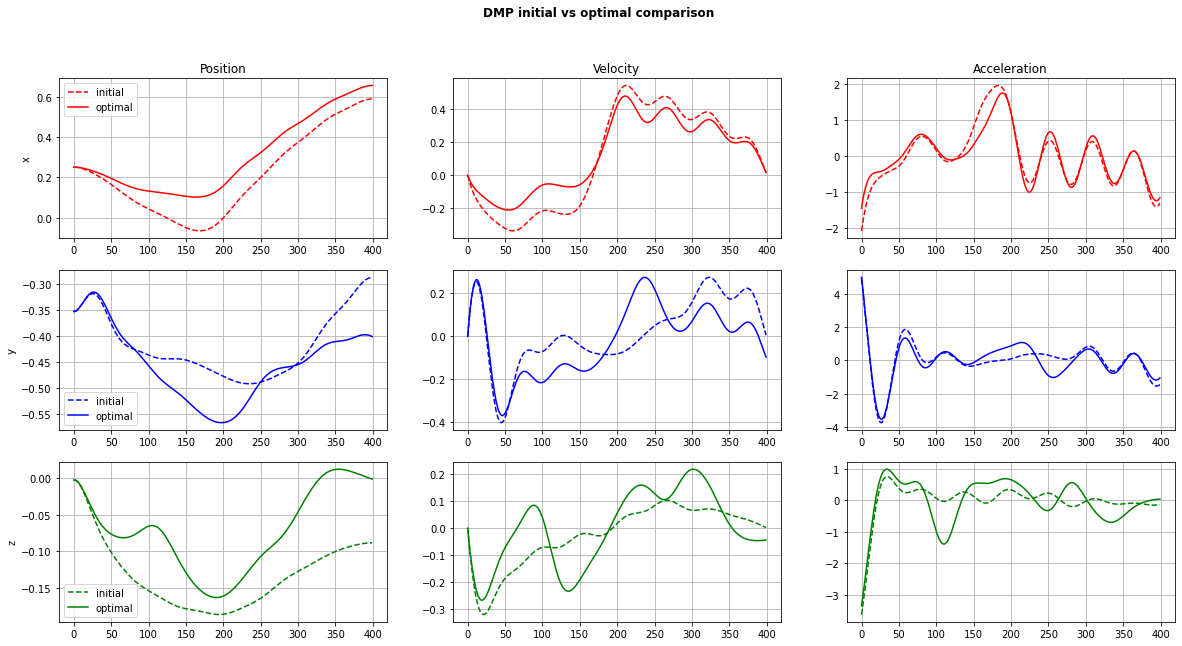

In [31]:
plot_dmps(results_folder)

In [41]:
traj = np.loadtxt("results_learning_wb_goal_covar_adapt/updates_rarm/update00000/eval_cost_vars.txt")

In [49]:
dmp_0 = jc.loadjson(results_folder + "/updates_rarm/update00000/eval_dmp.json")
ts_rarm = dmp_0.ts_train
xs, xds, forcing, fa_outputs, q_traj = dmp_0.analytical_solution()
traj_sample = dmp_0.states_as_trajectory(ts_rarm, xs, xds)

dmp_l = jc.loadjson(results_folder + "/updates_larm/update00000/eval_dmp.json")
ts_larm = dmp_l.ts_train
xs, xds, forcing, fa_outputs, q_traj = dmp_l.analytical_solution()
traj_sample_left = dmp_0.states_as_trajectory(ts_larm, xs, xds)

In [46]:
traj_sample.ys.shape

(400, 3)

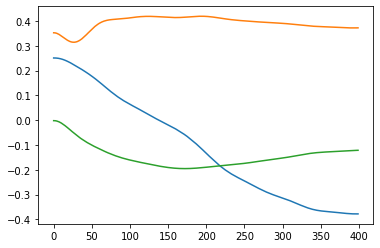

In [51]:
# plt.plot(traj_sample.ys)
plt.plot(traj_sample_left.ys)

In [53]:
traj_sample.ys[149]

array([-0.04768832, -0.4454283 , -0.17868632])

In [54]:
traj_sample_left.ys[149]

array([-0.01774773,  0.4146946 , -0.19042965])